In [322]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import StaleElementReferenceException
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup
import time
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [393]:
pd.set_option('display.max_columns', None)
matches = pd.read_csv("matches_with_everything_18-24.csv")
matches

,home_team,away_team,home_goals,away_goals,date,round,Ball Possession_home,Ball Possession_away,Goal Attempts_home,Goal Attempts_away,Shots on Goal_home,Shots on Goal_away,Shots off Goal_home,Shots off Goal_away,Blocked Shots_home,Blocked Shots_away,Free Kicks_home,Free Kicks_away,Corner Kicks_home,Corner Kicks_away,Offsides_home,Offsides_away,Throw-ins_home,Throw-ins_away,Goalkeeper Saves_home,Goalkeeper Saves_away,Fouls_home,Fouls_away,Yellow Cards_home,Yellow Cards_away,Total Passes_home,Total Passes_away,Completed Passes_home,Completed Passes_away,Tackles_home,Tackles_away,Attacks_home,Attacks_away,Dangerous Attacks_home,Dangerous Attacks_away,Red Cards_home,Red Cards_away,season,Expected Goals (xG)_home,Expected Goals (xG)_away,Clearances Completed_home,Clearances Completed_away,home_goals_y,away_goals_y,date_y,referee,stadium,capacity,attendance,stadium name,stadium city,Stadium,Club,Location,Opened,Capacity,Pitch length m,Pitch width m,latitude,longitude,longitude_decimal,latitude_decimal,outcome,home_points,away_points,datetime,time,home_last5_total_points,home_last5_goals_scored,home_last5_goals_conceded,home_last5_goal_difference,home_last5_Goal Attempts,home_last5_Shots on Goal,home_last5_Shots off Goal,home_last5_Ball Possession,home_last5_Blocked Shots,home_last5_Free Kicks,home_last5_Corner Kicks,home_last5_Offsides,home_last5_Throw-ins,home_last5_Goalkeeper Saves,home_last5_Fouls,home_last5_Yellow Cards,home_last5_Total Passes,home_last5_Completed Passes,home_last5_Tackles,home_last5_Attacks,home_last5_Dangerous Attacks,home_last5_Red Cards,home_last5_Expected Goals (xG),home_last5_Clearances Completed,away_last5_total_points,away_last5_goals_scored,away_last5_goals_conceded,away_last5_goal_difference,away_last5_Goal Attempts,away_last5_Shots on Goal,away_last5_Shots off Goal,away_last5_Ball Possession,away_last5_Blocked Shots,away_last5_Free Kicks,away_last5_Corner Kicks,away_last5_Offsides,away_last5_Throw-ins,away_last5_Goalkeeper Saves,away_last5_Fouls,away_last5_Yellow Cards,away_last5_Total Passes,away_last5_Completed Passes,away_last5_Tackles,away_last5_Attacks,away_last5_Dangerous Attacks,away_last5_Red Cards,away_last5_Expected Goals (xG),away_last5_Clearances Completed,home_total_points,away_total_points,home_goals_scored,away_goals_scored,home_goals_conceded,away_goals_conceded,home_goal_difference,away_goal_difference,home_Ball Possession,away_Ball Possession,home_Goal Attempts,away_Goal Attempts,home_Shots on Goal,away_Shots on Goal,home_Shots off Goal,away_Shots off Goal,home_Blocked Shots,away_Blocked Shots,home_Free Kicks,away_Free Kicks,home_Corner Kicks,away_Corner Kicks,home_Offsides,away_Offsides,home_Throw-ins,away_Throw-ins,home_Goalkeeper Saves,away_Goalkeeper Saves,home_Fouls,away_Fouls,home_Yellow Cards,away_Yellow Cards,home_Total Passes,away_Total Passes,home_Completed Passes,away_Completed Passes,home_Tackles,away_Tackles,home_Attacks,away_Attacks,home_Dangerous Attacks,away_Dangerous Attacks,home_Red Cards,away_Red Cards,home_Expected Goals (xG),away_Expected Goals (xG),home_Clearances Completed,away_Clearances Completed
0,Arsenal,Everton,5,1,2022-05-22,38,74,26,26,6,9,2,8,3,9,1,8,9,12,2,2,0,12.0,13.0,1,4,8,9,0.0,1.0,647,234,583.0,151.0,12,21,136,55,89,25,0.0,0.0,21-22,-1.0,-1.0,0.0,0.0,5.0,1.0,22.05.2022 17:00,Marriner A. (Eng),Emirates Stadium (London),60 704,60 201,Emirates Stadium,London,Emirates Stadium,Arsenal,London,2006,60704,105.00,68.0,51°33′18″N,000°06′31″W,-0.108611,51.555000,1,3,0,2022-05-22 17:00:00,17:00:00,1.800000,1.400000,1.600000,-0.200000,13.200000,6.000000,4.600000,50.600000,2.600000,11.000000,5.200000,0.800000,17.0,2.400000,10.800000,3.000000,465.2,392.4,12.600000,104.600000,50.800000,0.2,-1.0,0.0,2.000000,1.600000,1.200000,0.400000,11.400000,4.800000,4.000000,35.800000,2.600000,9.000000,5.200000,0.600000,17.2,4.000000,8.800000,1.400000,315.200000,224.8,16.200000,95.000000,50.400000,0.4,-1.0,0.0,1.783784,1.054054,1.513514,1.135135,1.270270,1.648649,0.243243,-0.5

#### Przygotowanie ramki danych ze statystykami z ostatnich meczów

In [394]:
df_last5 = matches[[col for col in matches.columns if 'last5' in col or 'outcome' in col]]

In [395]:
df_last5
df_last5['outcome'] = df_last5['outcome'].replace('x', 0)
df_last5['outcome'] = df_last5['outcome'].replace('1', 1)
df_last5['outcome'] = df_last5['outcome'].replace('2', 2)
df_last5['outcome'].unique()

C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_27228\972497622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last5['outcome'] = df_last5['outcome'].replace('x', 0)
C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_27228\972497622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last5['outcome'] = df_last5['outcome'].replace('1', 1)
C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_27228\972497622.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will b

array([1, 2, 0], dtype=int64)

In [396]:
df_last5 = df_last5[['outcome', 'home_last5_total_points', 'away_last5_total_points', 'home_last5_goal_difference', 'away_last5_goal_difference', 'home_last5_Goal Attempts', 'away_last5_Goal Attempts', 'home_last5_Corner Kicks', 'away_last5_Corner Kicks', 'home_last5_Dangerous Attacks', 'away_last5_Dangerous Attacks', 'home_last5_Ball Possession', 'away_last5_Ball Possession']]

In [397]:
df_last5.groupby(['outcome']).mean()

,home_last5_total_points,away_last5_total_points,home_last5_goal_difference,away_last5_goal_difference,home_last5_Goal Attempts,away_last5_Goal Attempts,home_last5_Corner Kicks,away_last5_Corner Kicks,home_last5_Dangerous Attacks,away_last5_Dangerous Attacks,home_last5_Ball Possession,away_last5_Ball Possession
outcome,,,,,,,,,,,,
0,1.306882,1.406774,-0.146057,0.011075,12.148208,12.698208,4.966272,5.264695,48.058136,50.289247,48.533333,50.079821
1,1.540018,1.274303,0.249630,-0.196526,13.272716,12.193862,5.427425,4.988430,52.353774,48.071411,52.322787,48.079912
2,1.186981,1.580966,-0.314928,0.329396,11.817488,13.764855,4.888019,5.641087,46.768285,53.985266,47.649879,52.889928


#### Wczytywanie danych do torcha

In [398]:
class FootballDataset(Dataset):
    def __init__(self, agg_stats):
        self.agg_stats = agg_stats.drop('outcome', axis=1).values  # Convert to numpy array
        self.labels = agg_stats['outcome'].values  # Convert to numpy array
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Return features and labels as tensors
        features = torch.tensor(self.agg_stats[idx], dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, labels

In [399]:
dataset = FootballDataset(df_last5)
test_dataset = FootballDataset(df_last5)
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)

##### Customowa loss function - raczej się nie nadaje, ale można opisać próby jakby co póżniej

In [400]:
# def distance_penalty_loss(predictions, targets, penalty_factor=0.5):
#     # Apply softmax to get probabilities
#     predictions_probs = F.softmax(predictions, dim=1)

#     # Get the predicted class index (most confident prediction)
#     predicted_class = torch.argmax(predictions_probs, dim=1)
    
#     # Calculate the cross-entropy loss as usual
#     cross_entropy_loss = F.cross_entropy(predictions, targets, reduction='none')

#     # Calculate the distance between predicted class and true class
#     distance = (predicted_class != targets).float()
    
#     max_values, _ = torch.max(predictions_probs, dim=1)

#     # Apply a penalty based on the distance (e.g., penalty factor of 2.0)
#     penalty = 1 + penalty_factor * distance

#     # Return the mean penalized loss over the batch
#     penalized_loss = cross_entropy_loss * penalty * (max_values + 3)
#     return penalized_loss.mean()

#### Prosta sieć neuronowa z 3 warstwami

In [401]:
class FootballMatchPredictor(nn.Module):
    def __init__(self, input_agg_stats_size, hidden_size=32):
        super(FootballMatchPredictor, self).__init__()
        
        # Layer for aggregated statistics
        self.agg_stats_fc = nn.Sequential(
            nn.Linear(input_agg_stats_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU()
        )
        
        combined_input_size = hidden_size // 2
        self.fc_combined = nn.Sequential(
            nn.Linear(combined_input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 3),  # Output: 3 probabilities (home win/draw/away win)
        )

    def forward(self, agg_stats):

        agg_stats_out = self.agg_stats_fc(agg_stats)

        output = self.fc_combined(agg_stats_out)
        
        # Apply softmax to get probabilities
        return F.softmax(output, dim=1)

#### Narazie najlepsza loss function - która gwarantuje, że prawdopodbieństwo remisów nie jest zbyt małe jak w przypadku innych loss functions

In [410]:
def weighted_cross_entropy_loss(predictions, targets):
    smoothing = 0.3
    weight_matrix = torch.tensor([
    [1.0, 5.0, 5.0],  # True label is draw (heavier penalty for home/away win predictions)
    [1.0, 1.0, 2.0],  # True label is home win
    [1.0, 2.0, 1.0]   # True label is away win
    ])
    # Apply softmax to get probabilities
    predictions_probs = F.softmax(predictions, dim=1)
    
    # One-hot encode the target labels (0 = draw, 1 = home win, 2 = away win)
    one_hot_targets = F.one_hot(targets, num_classes=3).float()

    smoothed_targets = one_hot_targets.clone()
    for i, target in enumerate(targets):
        if target == 0:  # If the true class is 'draw'
            smoothed_targets[i] = torch.tensor([0.8, 0.1, 0.1])  # 0.8 for draw, 0.1 for home/away win
        elif target == 1:  # If the true class is 'home win'
            smoothed_targets[i] = torch.tensor([0.3, 0.65, 0.05])
        elif target == 2:  # If the true class is 'away win'
            smoothed_targets[i] = torch.tensor([0.3, 0.05, 0.65])
    

    # Calculate the cross-entropy loss for each class
    loss_per_class = -smoothed_targets * torch.log(predictions_probs)
    # Weight the loss based on the distance between predicted and true class
    # For each true class, apply the corresponding row of the weight matrix
    weights = weight_matrix[targets]  # Get the corresponding weight row for each true label
    weighted_loss = loss_per_class * weights

    # Return the mean weighted loss over the batch
    return weighted_loss.sum(dim=1).mean()


In [411]:
model = FootballMatchPredictor(12)

# Loss function and optimizer
criterion = weighted_cross_entropy_loss  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


# Training loop
num_epochs = 10 
batch_size = 8 

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):


        # # Move data to device (GPU/CPU)
        # inputs = inputs.to('cuda') if torch.cuda.is_available() else inputs
        # targets = targets.to('cuda') if torch.cuda.is_available() else targets
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Optimize weights
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Print average loss for the epoch
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the model
torch.save(model.state_dict(), 'football_match_predictor.pth')

Epoch 1/10: 100%|██████████| 525/525 [00:02<00:00, 196.51it/s]


Epoch [1/10], Loss: 1.3320


Epoch 2/10: 100%|██████████| 525/525 [00:02<00:00, 206.78it/s]


Epoch [2/10], Loss: 1.3288


Epoch 3/10: 100%|██████████| 525/525 [00:01<00:00, 270.59it/s]


Epoch [3/10], Loss: 1.3261


Epoch 4/10: 100%|██████████| 525/525 [00:01<00:00, 303.38it/s]


Epoch [4/10], Loss: 1.3230


Epoch 5/10: 100%|██████████| 525/525 [00:01<00:00, 297.51it/s]


Epoch [5/10], Loss: 1.3242


Epoch 6/10: 100%|██████████| 525/525 [00:01<00:00, 306.77it/s]


Epoch [6/10], Loss: 1.3236


Epoch 7/10: 100%|██████████| 525/525 [00:01<00:00, 311.87it/s]


Epoch [7/10], Loss: 1.3230


Epoch 8/10: 100%|██████████| 525/525 [00:01<00:00, 308.27it/s]


Epoch [8/10], Loss: 1.3240


Epoch 9/10: 100%|██████████| 525/525 [00:01<00:00, 280.57it/s]


Epoch [9/10], Loss: 1.3225


Epoch 10/10: 100%|██████████| 525/525 [00:01<00:00, 329.12it/s]

Epoch [10/10], Loss: 1.3212


In [412]:
model.eval()

# To make predictions, you can create a DataLoader for your new data or use existing data.
# For this example, let's say we want to make predictions on the validation dataset.
# If you have a specific dataset or inputs, make sure it's in the correct format.

# Here we assume you want to predict on a subset of your training dataset for demonstration.
# If you're predicting on new data, load that data into a DataLoader accordingly.

with torch.no_grad():  # Disable gradient calculation for predictions
    predictions = []
    probabilities=[]
    actuals = []  # To store actual outcomes if you have them for comparison

    for inputs, targets in test_dataloader:  # You can replace dataloader with your validation/test DataLoader
        
        # Get model outputs
        outputs = model(inputs)  # Shape will be [batch_size, 3]
        
        # Get the predicted class indices (argmax to get the class with highest probability)
        _, predicted_classes = torch.max(outputs, dim=1)
        
        # Store predictions and actuals
        probabilities.extend(outputs)
        predictions.extend(predicted_classes.cpu().numpy())  # Convert to numpy for easy handling
        actuals.extend(targets.numpy())  # Store actual targets

# Now predictions contains the predicted class indices for the input data
# and actuals contains the true class labels (if available).

# Optionally, print the results
print("Predictions:", probabilities)
print("Predictions:", predictions)
print("Actuals:    ", actuals)

# You can calculate accuracy or other metrics if you have actual labels
accuracy = (np.array(predictions) == np.array(actuals)).mean()
print(f'Accuracy: {accuracy:.4f}')

Predictions: [tensor([0.3465, 0.5136, 0.1399]), tensor([0.3340, 0.5782, 0.0878]), tensor([0.3463, 0.4252, 0.2285]), tensor([0.3467, 0.4447, 0.2086]), tensor([0.2641, 0.7078, 0.0281]), tensor([0.3256, 0.5850, 0.0894]), tensor([0.3549, 0.4280, 0.2172]), tensor([0.2664, 0.7010, 0.0327]), tensor([0.2666, 0.7011, 0.0324]), tensor([0.3581, 0.2516, 0.3903]), tensor([0.3444, 0.4352, 0.2203]), tensor([0.2915, 0.6465, 0.0621]), tensor([0.3536, 0.1420, 0.5044]), tensor([0.3123, 0.1038, 0.5838]), tensor([0.3641, 0.2912, 0.3447]), tensor([0.3732, 0.3503, 0.2765]), tensor([0.3594, 0.2526, 0.3879]), tensor([0.3644, 0.2786, 0.3570]), tensor([0.3432, 0.1598, 0.4970]), tensor([0.3344, 0.1522, 0.5134]), tensor([0.3571, 0.4400, 0.2029]), tensor([0.3502, 0.4384, 0.2115]), tensor([0.3515, 0.2082, 0.4403]), tensor([0.3449, 0.1703, 0.4848]), tensor([0.3350, 0.5416, 0.1235]), tensor([0.3508, 0.5103, 0.1389]), tensor([0.3172, 0.1084, 0.5744]), tensor([0.3326, 0.1408, 0.5266]), tensor([0.2931, 0.6597, 0.0472]), 

Original Accuracy: 0.4514


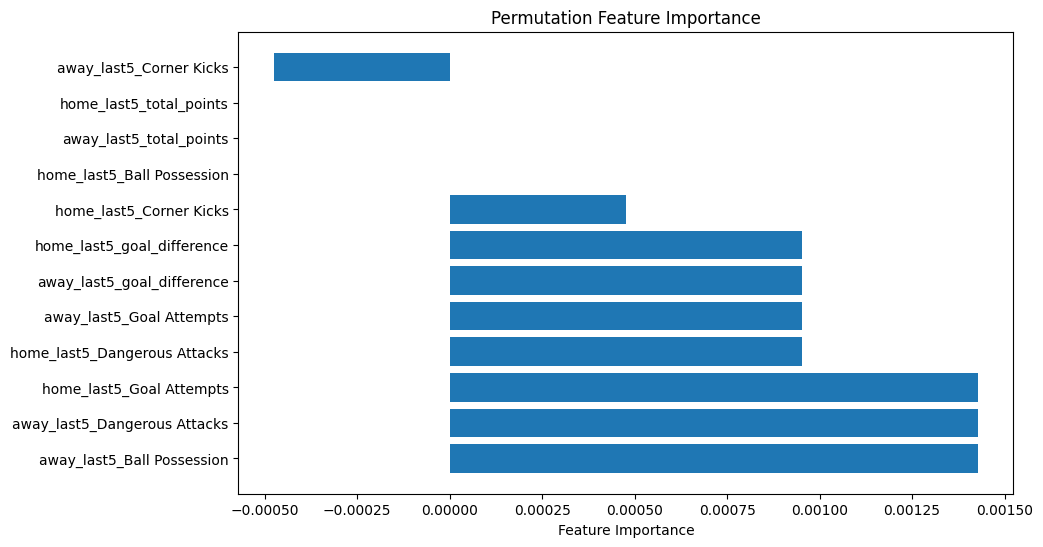

In [405]:
model.eval()

# Create a DataLoader for the validation data
validation_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)

# Function to calculate model accuracy
def calculate_accuracy(loader):
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            # inputs = inputs.to(device)
            outputs = model(inputs)
            predicted_classes = torch.argmax(outputs, dim=1)
            total_correct += (predicted_classes.cpu().numpy() == targets.numpy()).sum()
            total_samples += targets.size(0)
    
    return total_correct / total_samples

# Calculate the accuracy of the original model
original_accuracy = calculate_accuracy(validation_loader)

print(f'Original Accuracy: {original_accuracy:.4f}')

# Initialize a list to hold importances
importances = []

# Calculate importance for each feature
num_features = dataset.agg_stats.shape[1]

for i in range(num_features):  # Loop over each feature
    # Store the original values of the feature
    original_values = dataset.agg_stats[:, i].copy()

    # Shuffle the feature values
    dataset.agg_stats[:, i] = np.random.permutation(dataset.agg_stats[:, i])

    # Calculate accuracy on the shuffled dataset
    shuffled_accuracy = calculate_accuracy(validation_loader)

    # Restore the original feature values
    dataset.agg_stats[:, i] = original_values

    # Calculate the importance (drop in accuracy)
    importance = original_accuracy - shuffled_accuracy
    importances.append(importance)

# Convert importances to a numpy array for easier handling
feature_importance = np.array(importances)


# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_idx]

feature_names = df_last5.columns.drop('outcome').tolist()

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
plt.yticks(range(len(sorted_importance)), np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Permutation Feature Importance')
plt.show()